In [1]:
from helpers.get_bybit_http import get_client
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt 

client = get_client(testnet=False)

response = client.get_open_interest(
    category="linear",
    symbol="BTCUSDT",
    intervalTime="1h",
    limit=200
).get('result', {}).get('list', [])

response[:10]


[{'openInterest': '48207.33900000', 'timestamp': '1744048800000'},
 {'openInterest': '48654.86500000', 'timestamp': '1744045200000'},
 {'openInterest': '49306.72800000', 'timestamp': '1744041600000'},
 {'openInterest': '49174.12400000', 'timestamp': '1744038000000'},
 {'openInterest': '52057.63100000', 'timestamp': '1744034400000'},
 {'openInterest': '51388.99800000', 'timestamp': '1744030800000'},
 {'openInterest': '50582.16900000', 'timestamp': '1744027200000'},
 {'openInterest': '50717.87800000', 'timestamp': '1744023600000'},
 {'openInterest': '51039.16000000', 'timestamp': '1744020000000'},
 {'openInterest': '50855.31900000', 'timestamp': '1744016400000'}]

In [2]:
def format_bybit_oi(response: list[dict]) -> pd.DataFrame:
    if not response:
        return pd.DataFrame()
    df = pd.DataFrame(response)
    df['timestamp'] = df.timestamp.astype(int)
    df['openInterest'] = df.openInterest.astype(float)
    df.index = pd.to_datetime(df.timestamp, unit='ms', utc=True)
    return df.sort_index()

oi_data = format_bybit_oi(response=response)
print(oi_data)

                           openInterest      timestamp
timestamp                                             
2025-03-30 11:00:00+00:00     52735.708  1743332400000
2025-03-30 12:00:00+00:00     52672.541  1743336000000
2025-03-30 13:00:00+00:00     52718.827  1743339600000
2025-03-30 14:00:00+00:00     52627.547  1743343200000
2025-03-30 15:00:00+00:00     52828.837  1743346800000
...                                 ...            ...
2025-04-07 14:00:00+00:00     52057.631  1744034400000
2025-04-07 15:00:00+00:00     49174.124  1744038000000
2025-04-07 16:00:00+00:00     49306.728  1744041600000
2025-04-07 17:00:00+00:00     48654.865  1744045200000
2025-04-07 18:00:00+00:00     48207.339  1744048800000

[200 rows x 2 columns]


In [ ]:

import time

def get_last_timestamp(df):
    return int(df.timestamp[-1:].values[0])

def increment_oi_timestamp(
    start_ts: int, unit: str, n_units: int
) -> int:
    increments = {
        "1min": 60 * 1000,
        "5min": 5 * 60 * 1000,
        "15min": 15 * 60 * 100,
        "30min": 30 * 60 * 1000,
        "1h": 60 * 60 * 1000,
        "4h": 4 * 60 * 60 * 100,
        "D": 24 * 60 * 60 * 1000,
    }
    new_ts = increments[unit] * n_units + start_ts
    return new_ts



start = int(dt.datetime(2022, 1, 1, tzinfo=dt.timezone.utc).timestamp()* 1000)

interval = "15min"
symbol = 'BTCUSDT'
all_oi = pd.DataFrame()
end = increment_oi_timestamp(start_ts=start, unit=interval, n_units=199)
while True:
    response = client.get_open_interest(category='linear', 
                                 symbol=symbol, 
                                 startTime=start,
                                 endTime=end,
                                 intervalTime=interval, limit=200)
    
    latest = format_bybit_oi(response.get('result', {}).get('list',[]))
    start = get_last_timestamp(latest)
    end = increment_oi_timestamp(start_ts=start, unit=interval, n_units=199)
    time.sleep(0.01)
    all_oi = pd.concat([all_oi, latest])
    print(f'Collecting data starting {dt.datetime.fromtimestamp(start/1000)}')
    if len(latest) == 1: break


all_oi.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)

In [ ]:
## save open interest data to same folder as OHLC
all_oi.to_csv('data/BTC_USDT_OI_15min.csv', index=False)

Text(0, 0.5, 'BTC Open Contracts (BTC units)')

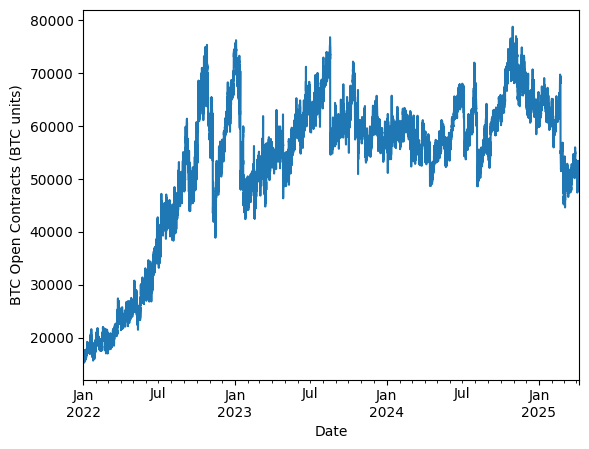

In [22]:
all_oi['openInterest'].plot()
plt.xlabel('Date')
plt.ylabel('BTC Open Contracts (BTC units)')

In [ ]:
## resample to different timeframe 
VALID_RESAMPLE_INTERVALS = ["1min", "5min", "15min", "30min", "h", "D", "W"]

def resample_bybit_oi(df: pd.DataFrame, new_interval: str) -> pd.DataFrame:
    return df.resample(new_interval).agg({
        "timestamp": "first",
        "openInterest": "first"
    })

oi_daily = resample_bybit_oi(df=all_oi, new_interval='D')
print(oi_daily)

                               timestamp  openInterest
timestamp                                             
2022-01-01 00:00:00+00:00  1640995200000     15863.152
2022-01-02 00:00:00+00:00  1641081600000     15636.474
2022-01-03 00:00:00+00:00  1641168000000     15370.184
2022-01-04 00:00:00+00:00  1641254400000     17275.287
2022-01-05 00:00:00+00:00  1641340800000     15976.977
...                                  ...           ...
2025-04-03 00:00:00+00:00  1743638400000     49369.163
2025-04-04 00:00:00+00:00  1743724800000     48211.773
2025-04-05 00:00:00+00:00  1743811200000     50905.811
2025-04-06 00:00:00+00:00  1743897600000     50464.327
2025-04-07 00:00:00+00:00  1743984000000     52375.214

[1193 rows x 2 columns]


## Long Short Ratio 

In [ ]:

start = int(dt.datetime(2022, 1, 1, tzinfo=dt.timezone.utc).timestamp()* 1000)
peiod = "15min"
symbol = 'BTCUSDT'
all_long_short = pd.DataFrame()
end = increment_oi_timestamp(start_ts=start, unit='15min', n_units=199)
response =client.get_long_short_ratio(category='linear', symbol=symbol, startTime=start,endTime=end, period=interval, limit=500)



In [ ]:
response.get('result').get('list')[:10]

In [ ]:
## get all long short ratio 
def format_long_short_ratio(response: list[dict]) -> pd.DataFrame:
    if not response:
        return pd.DataFrame()
    df = pd.DataFrame(response)
    df['buyRatio'] = df.buyRatio.astype(float)
    df['sellRatio'] = df.sellRatio.astype(float)
    df['long_short_ratio'] = df.buyRatio / df.sellRatio
    df['timestamp'] = df.timestamp.astype(int)
    df.index = pd.to_datetime(df.timestamp, unit='ms', utc=True)
    return df.sort_index()


start = int(dt.datetime(2022, 1, 1, tzinfo=dt.timezone.utc).timestamp()* 1000)
peiod = "15min"
symbol = 'BTCUSDT'
all_long_short = pd.DataFrame()
end = increment_oi_timestamp(start_ts=start, unit='15min', n_units=199)

while True:
    response = client.get_long_short_ratio(category='linear', 
                                 symbol=symbol, 
                                 startTime=start,
                                 endTime=end,
                                 period=interval, limit=500)
    
    latest = format_long_short_ratio(response.get('result', {}).get('list',[]))
    start = get_last_timestamp(latest)
    end = increment_oi_timestamp(start_ts=start, unit=interval, n_units=199)
    time.sleep(0.01)
    all_long_short = pd.concat([all_long_short, latest])
    print(f'Collecting data starting {dt.datetime.fromtimestamp(start/1000)}')
    if len(latest) == 1: break

    
all_long_short.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)

In [ ]:
## 💾 to disk 
all_long_short.to_csv('data/BTCUSDT_long_short_15min.csv', index=False)

Text(0, 0.5, 'Frequency')

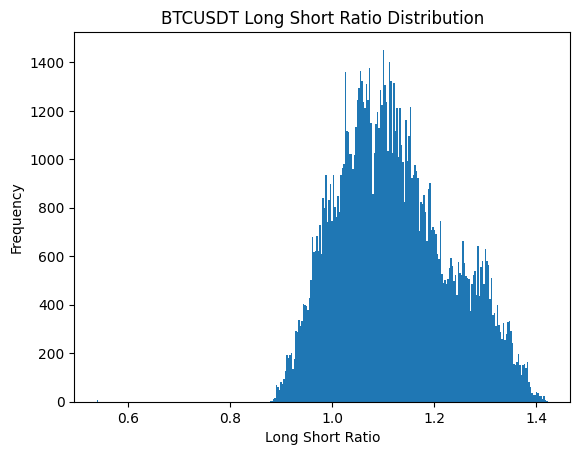

In [39]:
all_long_short.long_short_ratio.plot.hist(bins=300)
plt.title(f"BTCUSDT Long Short Ratio Distribution")
plt.xlabel(f"Long Short Ratio")
plt.ylabel(f"Frequency")
